<a href="https://www.kaggle.com/code/maro22/notebook0b7eae9c66?scriptVersionId=213706189" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=8685168e210272c81c6fedace284d5f2875e8999215385be8d5eef9855877abc
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import random
import cv2
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from tensorflow.keras.applications import DenseNet121
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras.layers import Dropout
from keras.initializers import RandomNormal
from keras.initializers import Zeros
from keras.initializers import Ones
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array
from imutils import paths
import gc
from keras.regularizers import l2
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import *
from keras.layers import *
import os
from imutils import paths
from keras import backend as K
from tensorflow.keras.optimizers import SGD
import matplotlib
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
import gc
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping


# **Preprocessing**

In [3]:
INPUT_SHAPE = (224, 224, 3)
AXIS = 3
NUM_CLASSES = 7

In [4]:
train_dataset="../input/cars-image-dataset/Cars Dataset/train"
test_dataset="../input/cars-image-dataset/Cars Dataset/test"

In [5]:
# Collect image paths
train_imagePaths = list(paths.list_images(train_dataset))
test_imagePaths = list(paths.list_images(test_dataset))

In [6]:
all_imagePaths = train_imagePaths + test_imagePaths
random.shuffle(all_imagePaths, random_state=42)

In [7]:
# Calculate channel means using training data
B_mean, G_mean, R_mean, count = 0, 0, 0, 0
for imagePath in train_imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (224, 224))
    B_mean += np.mean(image[:, :, 0])
    G_mean += np.mean(image[:, :, 1])
    R_mean += np.mean(image[:, :, 2])
    count += 1
B_mean /= count
G_mean /= count
R_mean /= count
mean = [B_mean, G_mean, R_mean]


In [8]:
# Function to load and preprocess images
def load_and_preprocess_images(imagePaths, mean):
    data, labels = [], []
    for imagePath in imagePaths:
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (224, 224))
        image = img_to_array(image)
        image -= mean
        data.append(image)
        
        label = imagePath.split(os.path.sep)[-2]
        labels.append(label)
    
    data = np.array(data, dtype="float") / 255.0
    labels = np.array(labels)
    return data, labels

In [9]:
# Load and preprocess training and test data
all_data, all_labels = load_and_preprocess_images(all_imagePaths, mean)

# Encode labels
le = LabelEncoder()
all_labels = le.fit_transform(all_labels)
all_labels = to_categorical(all_labels, num_classes=len(le.classes_))

In [10]:
# Split the combined data into train, validation, and test sets
trainX, tempX, trainY, tempY = train_test_split(all_data, all_labels, test_size=0.3, random_state=42)
valX, testX, valY, testY = train_test_split(tempX, tempY, test_size=0.5, random_state=42)

# Data augmentation
aug = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=2, restore_best_weights=True)

# ResNet34 Architecture

In [11]:
class ResNet34:
     def build(inputShape,classes):

            
        def Conv(inputs,kernels,size=(1,1),padding='same',strides=(1,1),relu=True,BN=True):
            net=Conv2D(kernels,size,strides=strides,padding=padding)(inputs)
            if BN:
                net=BatchNormalization()(net)
            if relu:
                net=Activation('relu')(net)
            return net
        
        def residual(inputs,kernels,first=False):
            if first:
                net=Conv(inputs,kernels,size=(3,3),strides=(2,2))
            else:
                net=Conv(inputs,kernels,size=(3,3))
            net=Conv(net,kernels,size=(3,3))
            if first:
                inputs=Conv(inputs,kernels,relu=False,strides=(2,2),BN=False)
            Add=add([net,inputs])
            net=BatchNormalization()(Add)
            net=Activation('relu')(net)
            return net
        
        X=Input(shape=inputShape)
        net=Conv(X,64,(7,7),strides=(2,2))
        
        net=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(net)
        net=residual(inputs=net,kernels=64)
        net=residual(inputs=net,kernels=64)
        net=residual(inputs=net,kernels=64)
        
        net=residual(inputs=net,kernels=128,first=True)
        net=residual(inputs=net,kernels=128)
        net=residual(inputs=net,kernels=128)
        net=residual(inputs=net,kernels=128)
        
        net=residual(inputs=net,kernels=256,first=True)
        net=residual(inputs=net,kernels=256)
        net=residual(inputs=net,kernels=256)
        net=residual(inputs=net,kernels=256)
        net=residual(inputs=net,kernels=256)
        net=residual(inputs=net,kernels=256)
        
        net=residual(inputs=net,kernels=512,first=True)
        net=residual(inputs=net,kernels=512)
        net=residual(inputs=net,kernels=512)
        
        net=GlobalAveragePooling2D()(net)
        
        outputs=Dense(classes,activation="softmax")(net)
        
        model=Model(X,outputs)
        
        return model

In [12]:
# Model setup (assuming ResNet is defined elsewhere)
model = ResNet34.build(INPUT_SHAPE, 7)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

# Train the model
H = model.fit(
    x=aug.flow(trainX, trainY, batch_size=32),
    validation_data=(valX, valY),
    steps_per_epoch=len(trainX) // 32,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734522882.061039      99 service.cc:145] XLA service 0x795054003970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734522882.061113      99 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734522882.061119      99 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734522898.948719      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 4/91 ━━━━━━━━━━━━━━━━━━━━ 7:10 5s/step - accuracy: 0.2378 - loss: 1.9681  

I0000 00:00:1734522913.906737      99 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_63', 192 bytes spill stores, 192 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_184', 56 bytes spill stores, 56 bytes spill loads



91/91 ━━━━━━━━━━━━━━━━━━━━ 87s 511ms/step - accuracy: 0.2659 - loss: 1.8952 - val_accuracy: 0.2496 - val_loss: 1.8936
Epoch 2/100
 1/91 ━━━━━━━━━━━━━━━━━━━━ 17s 191ms/step - accuracy: 0.3750 - loss: 1.8069

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3750 - loss: 1.8069 - val_accuracy: 0.2496 - val_loss: 1.8949
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 29s 296ms/step - accuracy: 0.3406 - loss: 1.7514 - val_accuracy: 0.2608 - val_loss: 1.8424
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2812 - loss: 1.8398 - val_accuracy: 0.2688 - val_loss: 1.8417
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 29s 295ms/step - accuracy: 0.3841 - loss: 1.6787 - val_accuracy: 0.2784 - val_loss: 1.9085
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5312 - loss: 1.4387 - val_accuracy: 0.2832 - val_loss: 1.8973
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 29s 298ms/step - accuracy: 0.4092 - loss: 1.5956 - val_accuracy: 0.2272 - val_loss: 3.0941
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4375 - loss: 1.6468 - val_accuracy: 0.2352 - val_loss: 4.2121
Epoch 9/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 29s 293ms/step - accuracy: 0.4680 - loss: 1.4939 - val_accuracy: 0.1824

In [13]:
loss, accuracy = model.evaluate(testX, testY)
print("Test accuracy:", accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8913 - loss: 0.3514
Test accuracy: 0.8944000005722046


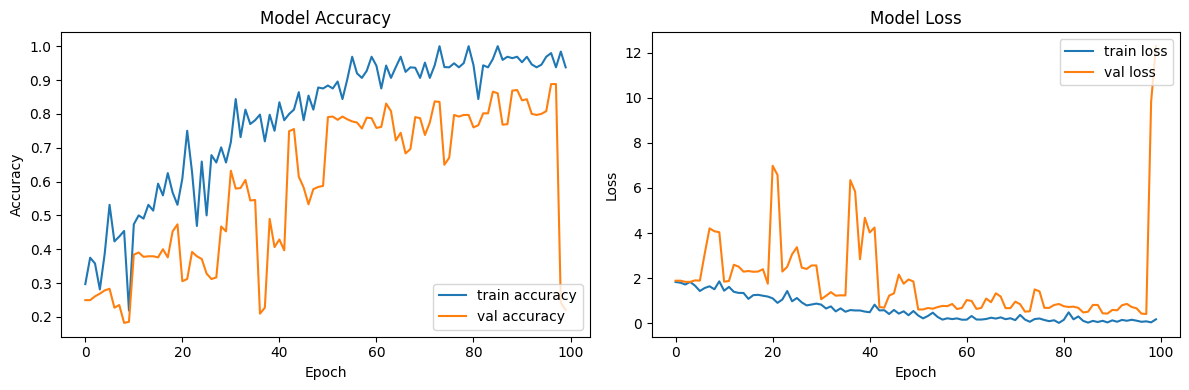

In [15]:
import matplotlib.pyplot as plt

# Assuming `H` is the history object returned by model.fit()
def plot_accuracy_and_loss(H):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(H.history['accuracy'], label='train accuracy')
    plt.plot(H.history['val_accuracy'], label='val accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(H.history['loss'], label='train loss')
    plt.plot(H.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_accuracy_and_loss(H)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step


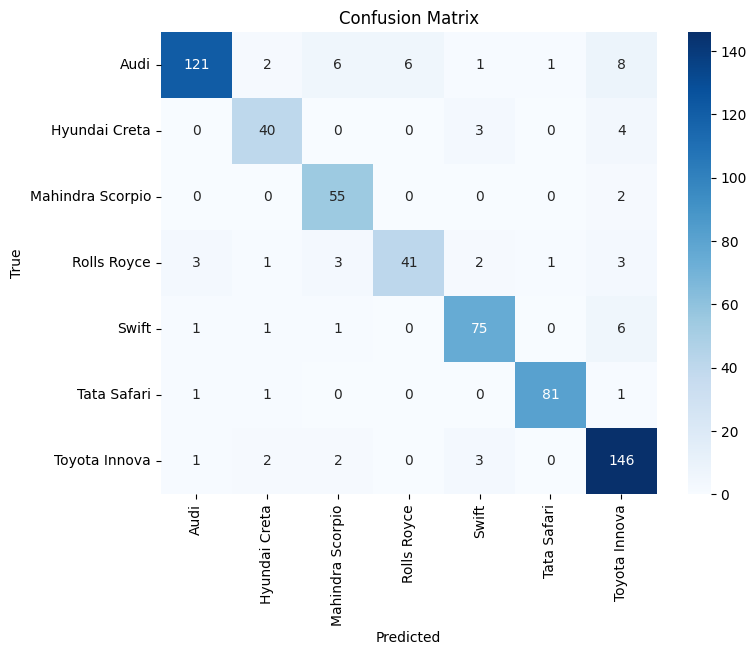

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming `testY` are the true labels and `predictions` are the predicted labels
def plot_confusion_matrix(testY, predictions, class_names):
    cm = confusion_matrix(testY, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
predictions = model.predict(testX).argmax(axis=1)
true_labels = testY.argmax(axis=1)
plot_confusion_matrix(true_labels, predictions, class_names=le.classes_)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


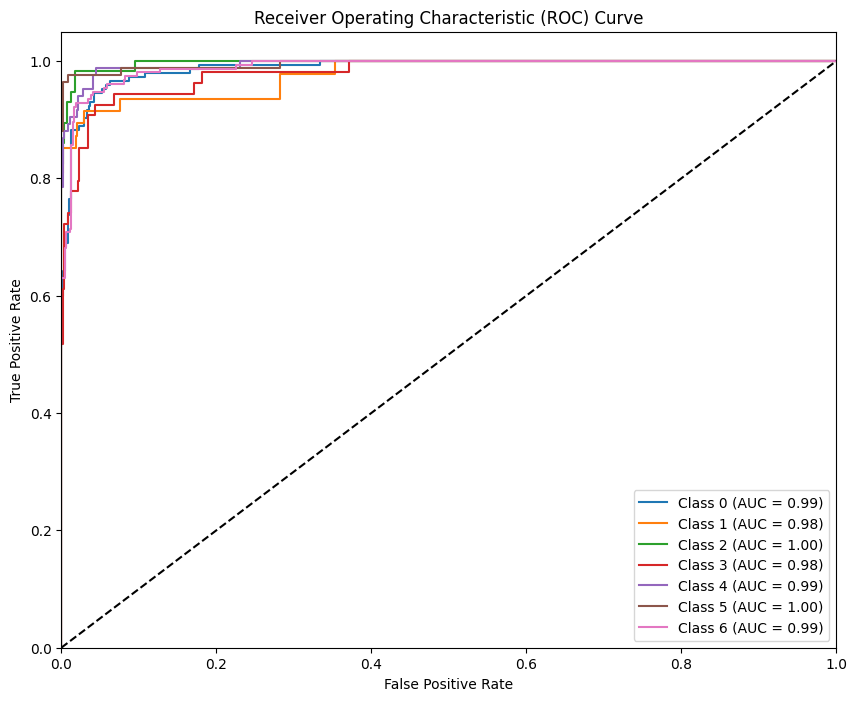

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming `testY` are the true labels and `predictions` are the predicted probabilities
def plot_roc_auc(testY, predictions, num_classes):
    # Binarize the output
    testY_bin = label_binarize(testY, classes=range(num_classes))
    fpr, tpr, roc_auc = dict(), dict(), dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(testY_bin[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Example usage
predictions_prob = model.predict(testX)
plot_roc_auc(true_labels, predictions_prob, num_classes=len(le.classes_))

 ------
 ------

# Densnet Arcticture Model

In [18]:
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model (optional if fine-tuning is not required)
densenet.trainable = False

for layer in densenet.layers[-100:]:
    layer.trainable = True


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
# Build the model
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
model2 = models.Sequential([
    densenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(7, activation='softmax')
])



model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
history2 = model2.fit(
    
    x=aug.flow(trainX, trainY, batch_size=32),
    validation_data=(valX, valY),
    steps_per_epoch=len(trainX) // 32,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 114s 713ms/step - accuracy: 0.6447 - loss: 1.0582 - val_accuracy: 0.8752 - val_loss: 0.5966
Epoch 2/100
 1/91 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.8750 - loss: 0.4962

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8750 - loss: 0.4962 - val_accuracy: 0.8688 - val_loss: 0.6487
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 28s 288ms/step - accuracy: 0.9192 - loss: 0.2512 - val_accuracy: 0.8912 - val_loss: 0.5226
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9062 - loss: 0.2762 - val_accuracy: 0.8896 - val_loss: 0.5099
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 28s 284ms/step - accuracy: 0.9639 - loss: 0.1330 - val_accuracy: 0.8864 - val_loss: 0.4307
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 0.8864 - val_loss: 0.4470
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step - accuracy: 0.9575 - loss: 0.1240 - val_accuracy: 0.8880 - val_loss: 0.5375
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.8768 - val_loss: 0.6126
Epoch 9/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 28s 288ms/step - accuracy: 0.9558 - loss: 0.1330 - val_accuracy: 0.9120

In [21]:
loss, accuracy = model2.evaluate(testX, testY)
print("Test accuracy:", accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9749 - loss: 0.1039
Test accuracy: 0.9775999784469604


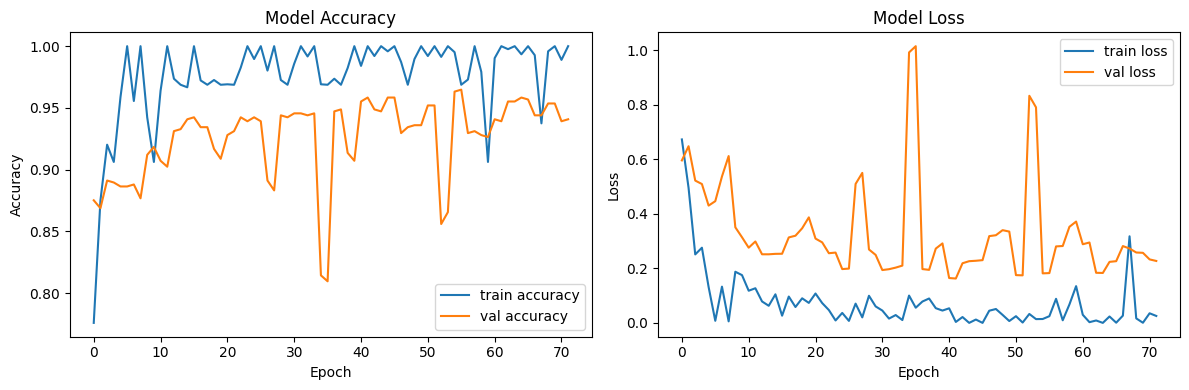

In [22]:
import matplotlib.pyplot as plt

# Assuming `H` is the history object returned by model.fit()
def plot_accuracy_and_loss(H):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(H.history['accuracy'], label='train accuracy')
    plt.plot(H.history['val_accuracy'], label='val accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(H.history['loss'], label='train loss')
    plt.plot(H.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_accuracy_and_loss(history2)

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 455ms/step


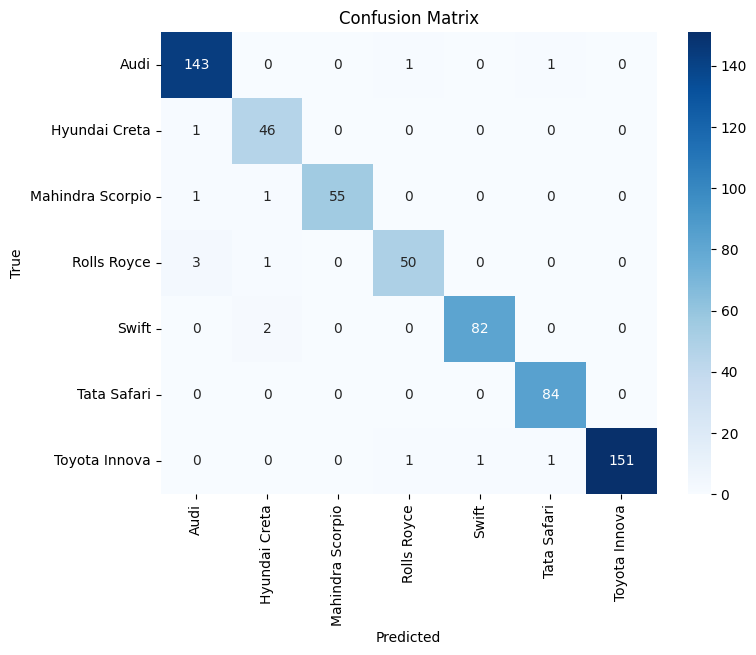

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming `testY` are the true labels and `predictions` are the predicted labels
def plot_confusion_matrix(testY, predictions, class_names):
    cm = confusion_matrix(testY, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
predictions = model2.predict(testX).argmax(axis=1)
true_labels = testY.argmax(axis=1)
plot_confusion_matrix(true_labels, predictions, class_names=le.classes_)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step


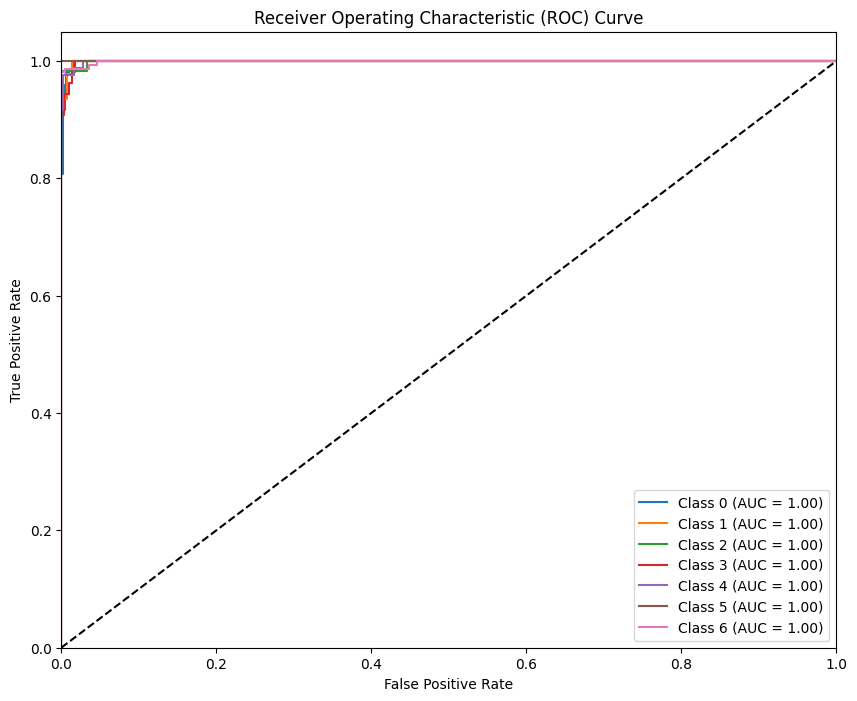

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming `testY` are the true labels and `predictions` are the predicted probabilities
def plot_roc_auc(testY, predictions, num_classes):
    # Binarize the output
    testY_bin = label_binarize(testY, classes=range(num_classes))
    fpr, tpr, roc_auc = dict(), dict(), dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(testY_bin[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Example usage
predictions_prob = model2.predict(testX)
plot_roc_auc(true_labels, predictions_prob, num_classes=len(le.classes_))

-------
-------

# Xception Arcticture Model

In [25]:
from tensorflow.keras.applications import Xception

xception = Xception(weights='imagenet', include_top=False)

xception.trainable = False

for layer in xception.layers[-100:]:
    layer.trainable = True

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
model3 = models.Sequential([
    xception,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(7, activation='softmax')
])


In [27]:
model3.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
history3 = model3.fit(
    
    x=aug.flow(trainX, trainY, batch_size=32),
    validation_data=(valX, valY),
    steps_per_epoch=len(trainX) // 32,
    epochs=100,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 100s 618ms/step - accuracy: 0.4764 - loss: 1.4206 - val_accuracy: 0.4112 - val_loss: 18.0158
Epoch 2/100
 1/91 ━━━━━━━━━━━━━━━━━━━━ 29s 325ms/step - accuracy: 0.7812 - loss: 0.7241

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7812 - loss: 0.7241 - val_accuracy: 0.4096 - val_loss: 17.8043
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 35s 364ms/step - accuracy: 0.8798 - loss: 0.4339 - val_accuracy: 0.7760 - val_loss: 1.4376
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9062 - loss: 0.2587 - val_accuracy: 0.7472 - val_loss: 1.7519
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 33s 344ms/step - accuracy: 0.9066 - loss: 0.3571 - val_accuracy: 0.6944 - val_loss: 2.0060
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9062 - loss: 0.3186 - val_accuracy: 0.7056 - val_loss: 1.9363
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 34s 354ms/step - accuracy: 0.9225 - loss: 0.2860 - val_accuracy: 0.7920 - val_loss: 0.7512
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9062 - loss: 0.1797 - val_accuracy: 0.8048 - val_loss: 0.6865
Epoch 9/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 34s 350ms/step - accuracy: 0.9462 - loss: 0.2060 - val_accuracy: 0.872

In [29]:
loss, accuracy = model3.evaluate(testX, testY)
print("Test accuracy:", accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9675 - loss: 0.1371
Test accuracy: 0.974399983882904


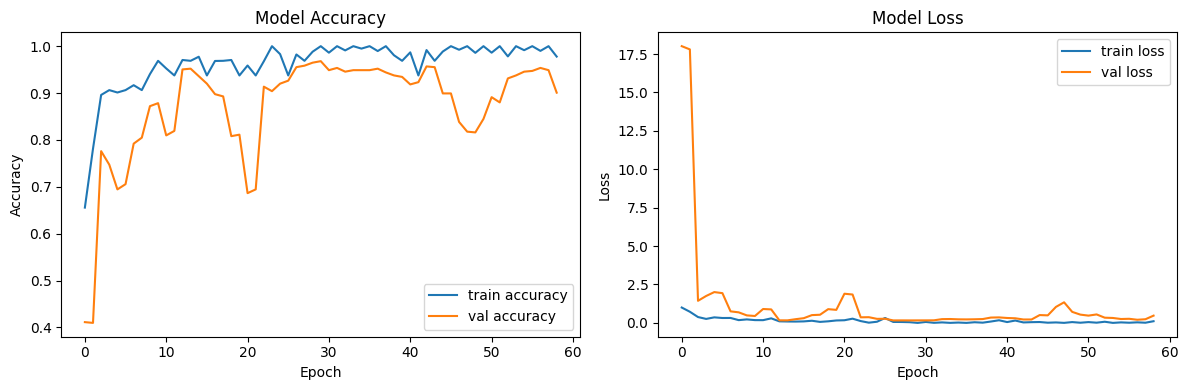

In [30]:
import matplotlib.pyplot as plt

# Assuming `H` is the history object returned by model.fit()
def plot_accuracy_and_loss(H):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(H.history['accuracy'], label='train accuracy')
    plt.plot(H.history['val_accuracy'], label='val accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(H.history['loss'], label='train loss')
    plt.plot(H.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_accuracy_and_loss(history3)

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step


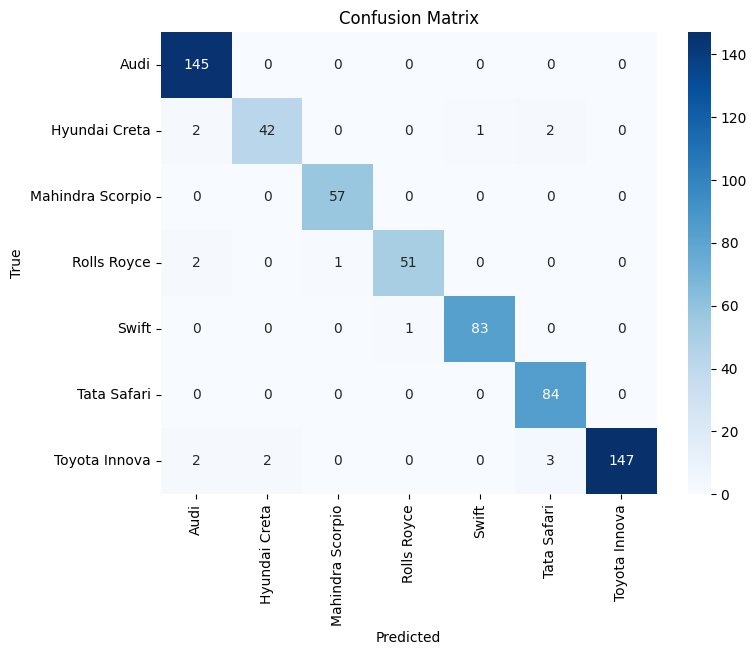

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming `testY` are the true labels and `predictions` are the predicted labels
def plot_confusion_matrix(testY, predictions, class_names):
    cm = confusion_matrix(testY, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
predictions = model3.predict(testX).argmax(axis=1)
true_labels = testY.argmax(axis=1)
plot_confusion_matrix(true_labels, predictions, class_names=le.classes_)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step


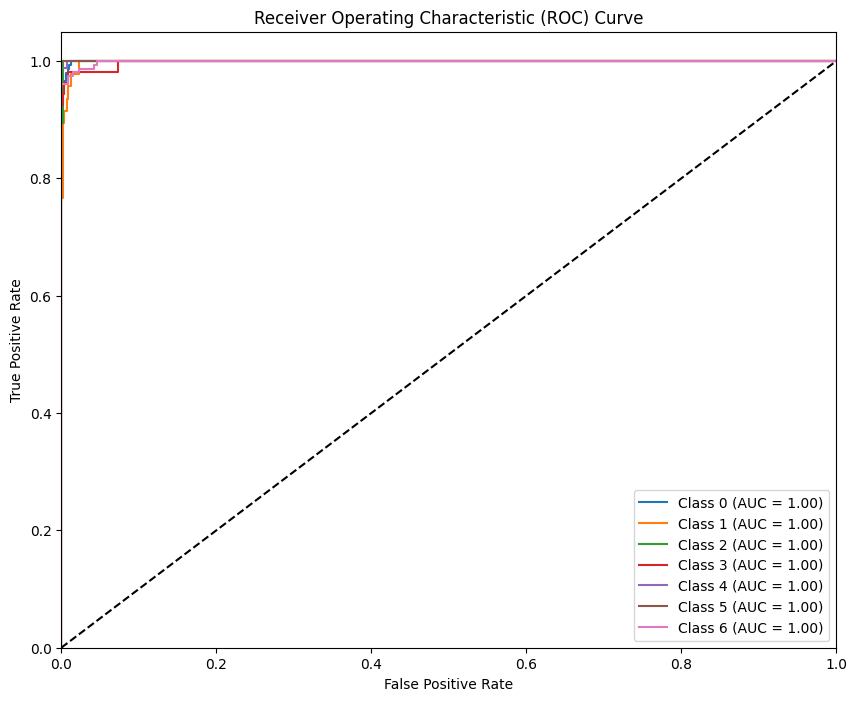

In [32]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming `testY` are the true labels and `predictions` are the predicted probabilities
def plot_roc_auc(testY, predictions, num_classes):
    # Binarize the output
    testY_bin = label_binarize(testY, classes=range(num_classes))
    fpr, tpr, roc_auc = dict(), dict(), dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(testY_bin[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Example usage
predictions_prob = model3.predict(testX)
plot_roc_auc(true_labels, predictions_prob, num_classes=len(le.classes_))